In [2]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime

from openmovement.load import CwaData

## Data extraction Using `openmovement` library

In [3]:
def extract_data(filename):
    with CwaData(filename, include_gyro=True, include_temperature=True) as cwa_data:
        # As an ndarray of [time,accel_x,accel_y,accel_z,temperature]
        sample_values = cwa_data.get_sample_values()
        space_values = sample_values[:, 1:4]
        norms = np.linalg.norm(space_values, axis=1)
        space_values = np.column_stack((space_values, norms))
        time_index = sample_values[:, 0]
        
        # As a pandas DataFrame
        samples = cwa_data.get_samples()

    return {
        'filename': filename,
        'space_values': space_values,
        'time_index': time_index,
        'df': samples
    }

def extract_patient(pt_number):
    # load the data
    non_paretic = extract_data(f'data/ReArm_{pt_number}_ac_np.cwa')
    paretic = extract_data(f'data/ReArm_{pt_number}_ac_p.cwa')

    # remove the beginning of the earlier dataset to make the start times match
    start = max(non_paretic['time_index'][0], paretic['time_index'][0])

    non_paretic['space_values'] = non_paretic['space_values'][non_paretic['time_index'] >= start]
    non_paretic['time_index'] = non_paretic['time_index'][non_paretic['time_index'] >= start]

    paretic['space_values'] = paretic['space_values'][paretic['time_index'] >= start]
    paretic['time_index'] = paretic['time_index'][paretic['time_index'] >= start]

    # remove the end of the longer dataset to make the lengths match
    length = min(non_paretic['time_index'].shape[0], paretic['time_index'].shape[0])
    
    non_paretic['space_values'] = non_paretic['space_values'][:length]
    non_paretic['time_index'] = non_paretic['time_index'][:length]

    paretic['space_values'] = paretic['space_values'][:length]
    paretic['time_index'] = paretic['time_index'][:length]

    # define the time index
    time_index = (non_paretic['time_index'] + paretic['time_index']) / 2

    space_values = np.stack((non_paretic['space_values'], paretic['space_values']), axis=1)
    
    return space_values, time_index

In [4]:
#space_values, time_index = extract_patient("C1P08_20210810_1")
space_values, time_index = extract_patient("C1P13_20211110_1")

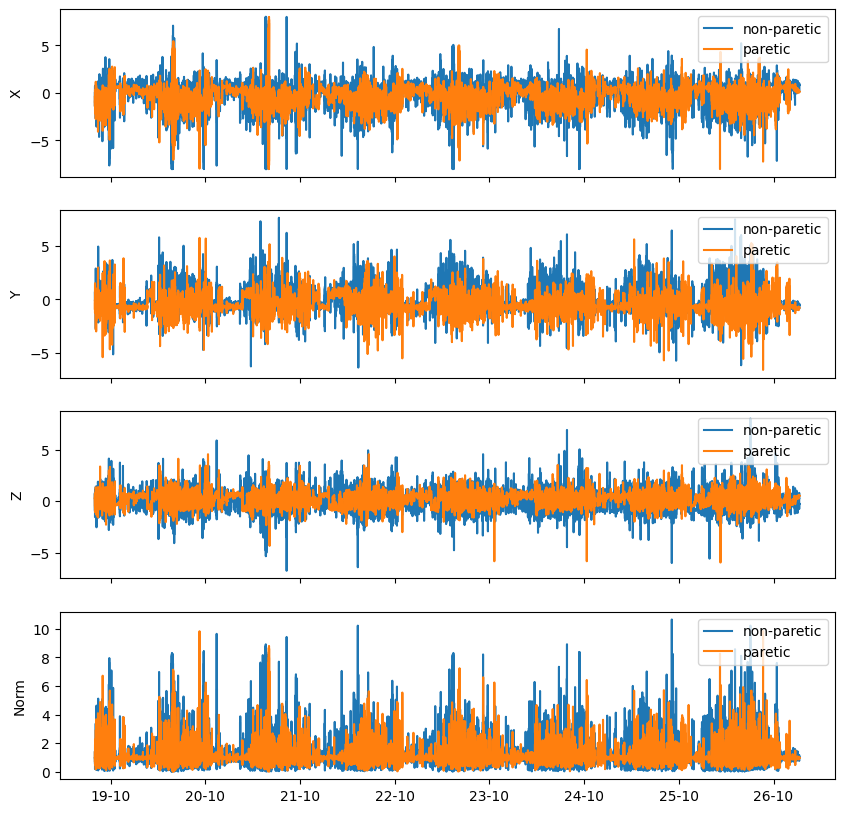

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i in range(4):
    ax[i].plot(pd.to_datetime(time_index, unit='s'), space_values[:, 0, i], label='non-paretic')
    ax[i].plot(pd.to_datetime(time_index, unit='s'), space_values[:, 1, i], label='paretic')
    ax[i].set_ylabel(['X', 'Y', 'Z', 'Norm'][i])
    ax[i].legend(loc='upper right')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.show()

## Jerk

In [6]:
space_values.shape

(31238160, 2, 4)

In [7]:
# J_i(t)=\frac{a_i(t+d t)-a_i(t-d t)}{2 d t},

jerk_xyz = (space_values[2:, :, 0:3] - space_values[:-2, :, 0:3]) / (2 * (time_index[2] - time_index[0]))
jerk_norm = np.linalg.norm(jerk_xyz, axis=2)
jerk_norm = jerk_norm.reshape(jerk_norm.shape[0], jerk_norm.shape[1], 1)

# small number to avoid division par zero
eps = 1e-6

jerk = np.concatenate((jerk_xyz, jerk_norm), axis=2) + eps

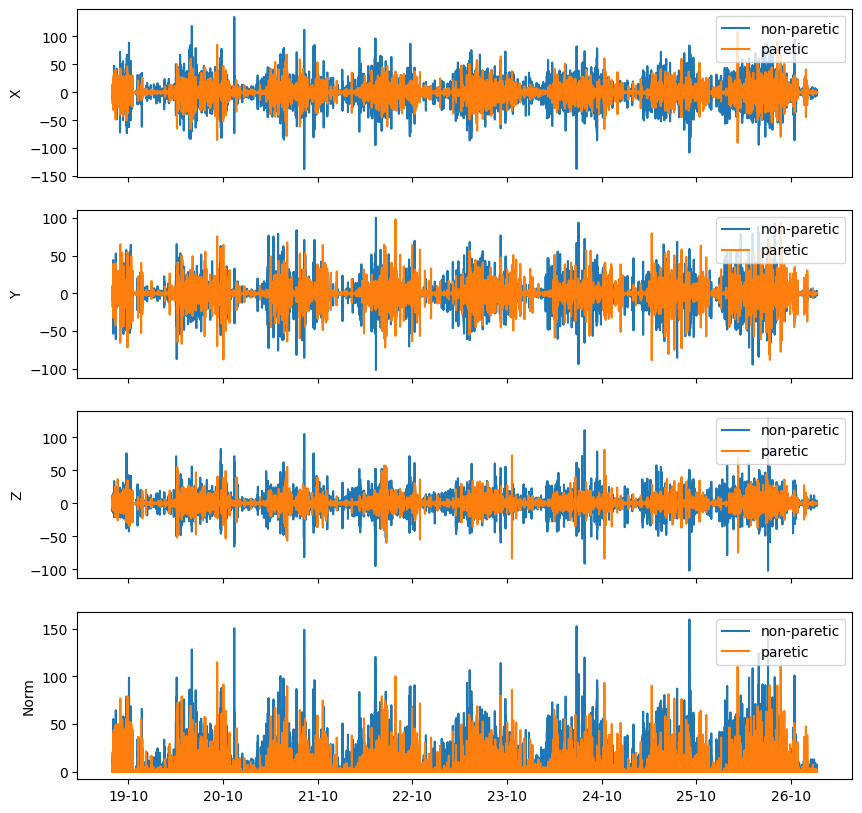

In [8]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i in range(4):
    ax[i].plot(pd.to_datetime(time_index[1:-1], unit='s'), jerk[:, 0, i], label='non-paretic')
    ax[i].plot(pd.to_datetime(time_index[1:-1], unit='s'), jerk[:, 1, i], label='paretic')
    ax[i].set_ylabel(['X', 'Y', 'Z', 'Norm'][i])
    ax[i].legend(loc='upper right')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.show()

In [9]:
# \operatorname{Jerk}_{\text {Ratio }}=2 x \frac{\mid \text { Jerk }_{\text {paretic }} \mid}{\mid \text { Jerk }_{\text {pareetic }}|+| \text { Jerk }_{\text {non-paretic }}}

jerk_ratio = 2 * np.abs(jerk[:, 1, 3]) / (np.abs(jerk[:, 0, 3]) + np.abs(jerk[:, 1, 3]))

(array([7025380.,   65712.,  114846.,  156419.,  186402.,  205066.,
         217915.,  219073.,  220081.,  221102.,  224346.,  207169.,
         209265.,  201279.,  197071.,  162135.,  215196.,  150526.,
         144223.,  203073.,   98100.,  211526.,   89344.,  138700.,
         144618.,  206056.,   96582.,   92674.,  213457.,   78097.,
         275537.,   50400.,  101333.,  142305.,   54895.,   58775.,
         309381.,   56937.,  135105.,   42749.,   54283., 1137640.,
          52191.,   63127.,  142059.,   35721.,   48728.,   60932.,
          37566.,   25519., 6643361.,   37042.,   58010.,   44774.,
          33298.,  132146.,   53932.,   44782., 1058178.,   44540.,
          35032.,  105888.,   43497.,  260496.,   43360.,   40131.,
         106060.,   69023.,   34620.,  199182.,   50638.,  146419.,
          55433.,   61639.,  121905.,   85486.,   78641.,   49424.,
         111753.,   50201.,   99746.,   69235.,   69824.,   96014.,
          70185.,   80563.,   80311.,   80410., 

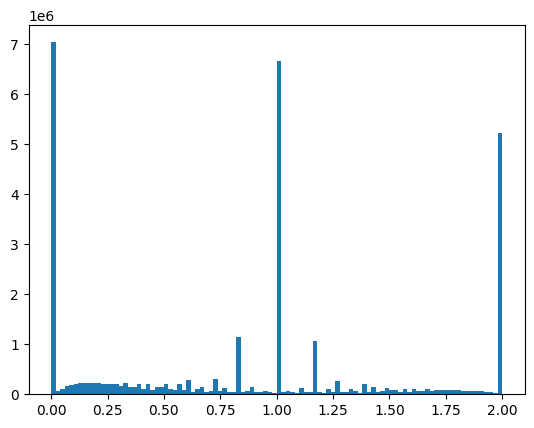

In [10]:
# histogram of jerk ratio
plt.hist(jerk_ratio, bins=100)

## Functional

In [11]:
space_values.shape

(31238160, 2, 4)

In [12]:
#\alpha(t)=\operatorname{arcos}\left(\frac{a_y(t)}{E N(t)}\right)
alpha = np.arccos(space_values[:, :, 1] / space_values[:, :, 3])

In [13]:
alpha.shape

(31238160, 2)

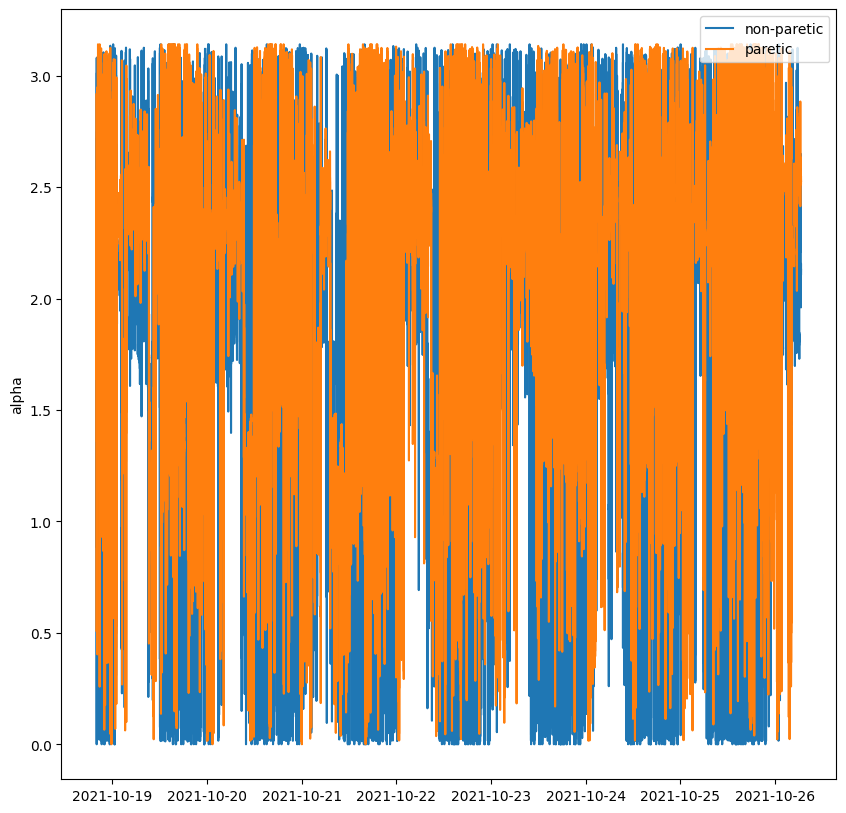

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True)

ax.plot(pd.to_datetime(time_index, unit='s'), alpha[:, 0], label='non-paretic')
ax.plot(pd.to_datetime(time_index, unit='s'), alpha[:, 1], label='paretic')
ax.set_ylabel('alpha')
ax.legend(loc='upper right')


In [84]:
def partition(space_values, time_index, seconds_per_window=5):
    delta_t = float(np.diff(time_index).mean())

    number_timepoints = space_values.shape[0]
    number_arms = space_values.shape[1]
    number_axis= space_values.shape[2]

    # partition the data into windows
    window_size = int(seconds_per_window / delta_t)
    num_windows = number_timepoints // window_size

    print(f"delta_t: {delta_t}")
    print(f"window_size: {window_size}")
    print(f"num_windows: {num_windows}")

    space_values = space_values[:num_windows * window_size]
    space_values = space_values.reshape((num_windows, window_size, number_arms, number_axis))

    time_index = time_index[:num_windows * window_size]
    time_index = time_index.reshape((num_windows, window_size))
    
    return space_values, time_index

In [85]:
windows_small, time_indexes_small = partition(space_values, time_index, seconds_per_window=0.5)

alphas = np.arccos(windows_small[:, :, :, 1] / windows_small[:, :, :, 3])
alphas = alphas - np.deg2rad(90)

delta_t: 0.020577736579621808
window_size: 24
num_windows: 1301590


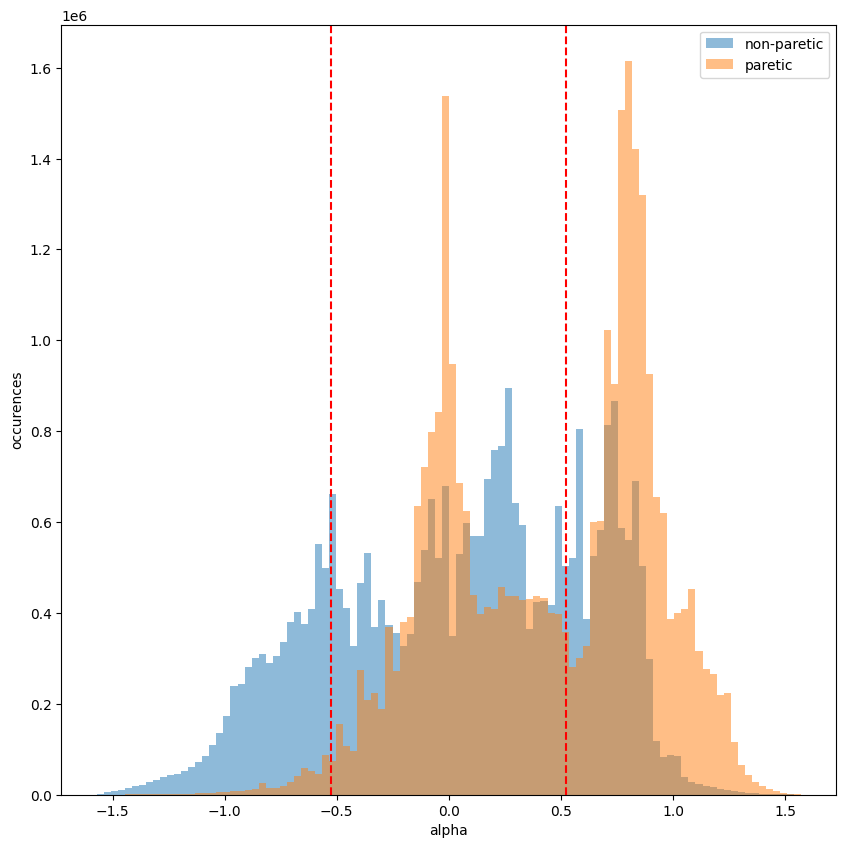

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True)

ax.hist(alphas[:, :, 0].flatten(), bins=100, alpha=0.5, label='non-paretic')
ax.hist(alphas[:, :, 1].flatten(), bins=100, alpha=0.5, label='paretic')

# mark +- 30 degrees
ax.axvline(np.deg2rad(30), color='r', linestyle='--')
ax.axvline(-np.deg2rad(30), color='r', linestyle='--')

ax.set_xlabel('alpha')
ax.set_ylabel('occurences')
ax.legend(loc='upper right')

plt.show()

In [87]:
#|\alpha| \leq 30^{\circ} \text { and } \alpha_{\text {max }}-\alpha_{\text {min }} \geq 30^{\circ} 
is_functional = (np.abs(alphas) <= np.deg2rad(30)).all(axis=1) & ((alphas.max(axis=1) - alphas.min(axis=1)) >= np.deg2rad(30))

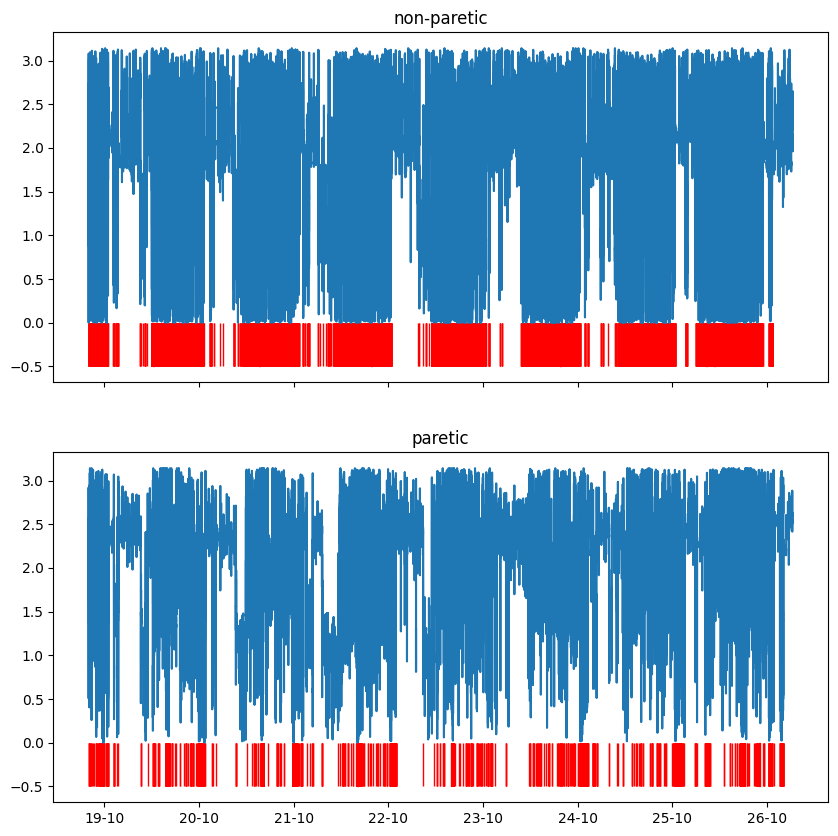

In [88]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

for i in range(2):
    ax[i].plot(pd.to_datetime(time_index, unit='s'), alpha[:, i])
    ax[i].set_title(['non-paretic', 'paretic'][i])

    for j in range(len(time_indexes_small)):
        if is_functional[j, i]:
            ax[i].fill_between(pd.to_datetime(time_indexes_small[j], unit='s'), -0.5, 0, color='red')
        
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))



## Features Extraction


In [204]:
#features_space = np.concatenate((space_values[1:-1, :, -1], jerk[:, :, 3])
features_space = np.stack((space_values[1:-1, :, -1], jerk[:, :, 3]), axis=2)

In [205]:
windows, time_indexes = partition(features_space, time_index[1:-1], seconds_per_window=5*60)

delta_t: 0.02057773657937426
window_size: 14578
num_windows: 2142


In [206]:
windows.shape

(2142, 14578, 2, 2)

In [207]:
def extract_features(window):
    features = []
    for j in range(window.shape[1]): # for each arm
        for i in range(window.shape[2]): # for each feature
            if i == 0: # acc
                features.append(window[:, j, i].std())
            if i == 1: # jerk
                features.append(window[:, j, i].mean())
                features.append(window[:, j, i].std())
                
    return np.array(features)

In [208]:
functional_movs = []
for t in time_indexes:
    # find interval of time_indexes_small that are inside t
    start = np.searchsorted(time_index, t[0])
    end = np.searchsorted(time_index, t[-1])

    # count the number of functional small windows
    functional_movs.append(is_functional[start:end].sum(axis=0))

functional_movs = np.array(functional_movs)

In [209]:
features = np.array([extract_features(window) for window in windows])
features = np.concatenate((features, functional_movs), axis=1)
print(features.shape)

# exclude the windows with zero functional movements in both arms
features = features[functional_movs.sum(axis=1) > 0]
# normalize (max-min)
features = (features - features.min(axis=0)) / (features.max(axis=0) - features.min(axis=0))

features.shape

(2142, 8)


(84, 8)

## Clustering

In [210]:
# ECM clustering
from evclust.ecm import ecm
number_clusters = 3
model = ecm(x=features, c=number_clusters, beta = 1.3,  alpha=2.2, delta=3, disp=False)

In [211]:
F = model['F']
focal_sets = [" \\cup ".join(["\\omega_{" + str(i+1) + "}" for i in range(len(f)) if f[i] == 1]) for f in F]
focal_sets[0] = "\emptyset"
mass_focal_sets = ['$m_{'+focal_sets[i]+'}$' for i in range(len(focal_sets))]
focal_sets = ['$'+f+'$' for f in focal_sets]

mass = model['mass']

In [212]:
from lib import decision_tree_imperfect

def create_edt(features_tree_generator = lambda x: x, edt_pars={}, plot_tree_pars={}):
    classifier = decision_tree_imperfect.EDT(**edt_pars)

    features_tree = features_tree_generator(features)

    print(features_tree.shape)

    y = mass.copy()

    classifier.fit(features_tree, y)

    diagram = classifier.plot_tree(**plot_tree_pars)

    plt.show()

    return diagram

In [213]:
cmap = plt.get_cmap('Pastel1')

cluster_base_colors = [np.array(cmap(0)), np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(4))]

focal_colors = []

for f in F:
    color = np.array([0., 0., 0., 0.])
    for i in range(len(f)):
        if f[i] == 1:
            color += cluster_base_colors[i+1]
    color = color/np.sum(f)

    cardinality_indication_color = np.array(cmap(7)) #np.array([0., 0., 0., 1.])

    color = color + (cardinality_indication_color - color) * (np.sum(f)-1)/(number_clusters-1)

    focal_colors.append(color)
focal_colors[0] = cluster_base_colors[0]

/var/folders/qn/sypqqw3101v1k6_70wqyd99h0000gn/T/ipykernel_54906/3096895718.py:12: RuntimeWarning: invalid value encountered in divide
  color = color/np.sum(f)


(84, 8)


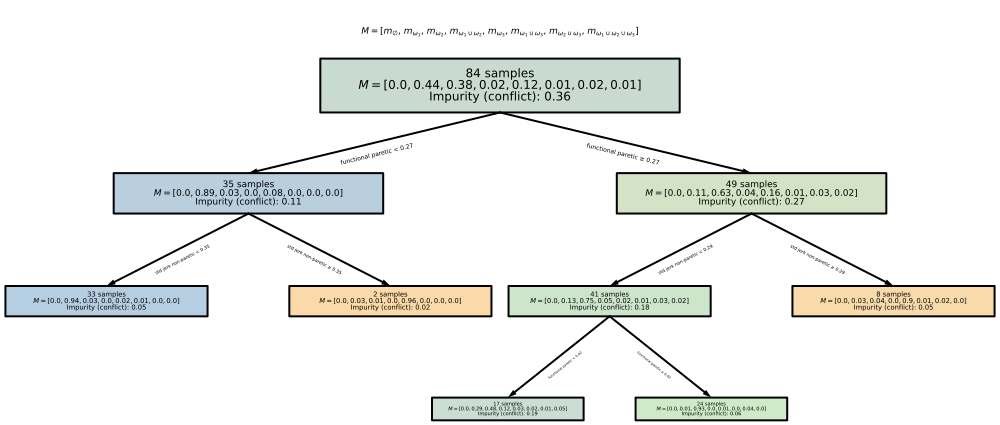

In [221]:
create_edt(
    edt_pars={
        'max_depth': 4,
        'criterion_treshold' : 0.1,
    },
    plot_tree_pars={
        'class_names' : mass_focal_sets,
        'focal_colors' : np.array(focal_colors),
        'feature_names' : ['std acc non-paretic', 'mean jerk non-paretic', 'std jerk non-paretic', 'std acc paretic', 'mean jerk paretic', 'functional non-paretic', 'functional paretic']
    }
)

In [227]:
centroids = []
for i in range(mass.shape[1]):
    centroid = np.zeros(features.shape[1])
    for point in range(len(features)):
        centroid += features[point] * mass[point, i]
    centroid /= np.sum(mass[:, i])

    if np.sum(F[i]) == 1:
        centroids.append(centroid)

# get vectors linking centroids
vectors = []
for i in range(len(centroids)):
    for j in range(i+1, len(centroids)):
        vectors.append(centroids[j] - centroids[i])

# for each vector get an orthonormal basis
orthonormal_bases = []
for vector in vectors:
    vector = vector / np.linalg.norm(vector)
    dimension = len(vector)
    orthonormal_basis = np.zeros((dimension, dimension))
    orthonormal_basis[:, 0] = vector
    orthonormal_basis[:, 1] = np.random.randn(dimension)
    orthonormal_basis[:, 1] -= np.dot(orthonormal_basis[:, 1], orthonormal_basis[:, 0]) * orthonormal_basis[:, 0]
    orthonormal_basis[:, 1] /= np.linalg.norm(orthonormal_basis[:, 1])
    orthonormal_bases.append(orthonormal_basis)

orthonormal_bases = np.array(orthonormal_bases)

def project_bases(features):
    # project features on the orthonormal basis
    projected_features = np.zeros((features.shape[0], features.shape[1]*orthonormal_bases.shape[0]))

    for i in range(orthonormal_bases.shape[0]):
        projected_features[:, i*features.shape[1]:(i+1)*features.shape[1]] = np.matmul(features, orthonormal_bases[i])

    projected_features = np.reshape(projected_features, (projected_features.shape[0], -1))

    return projected_features

(84, 24)


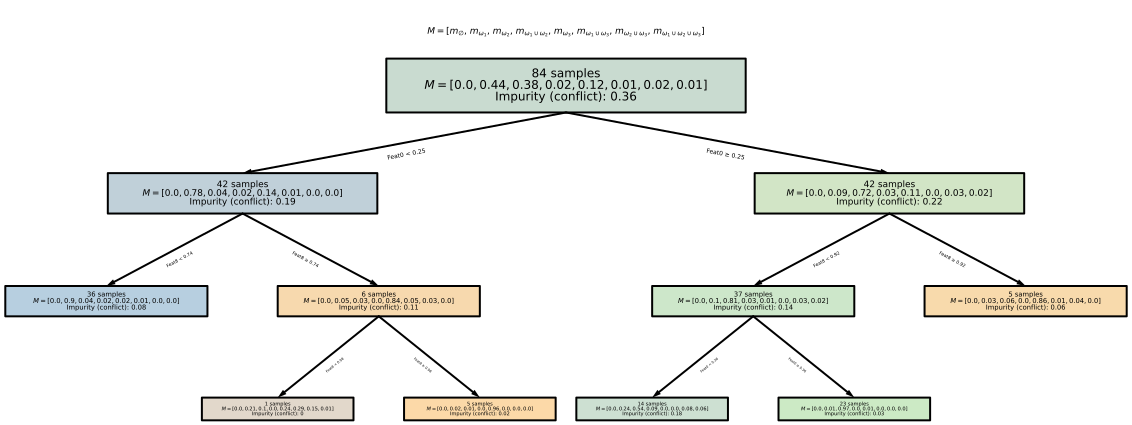

In [235]:
create_edt(
    features_tree_generator=project_bases,
    edt_pars={
        'max_depth': 4,
        'criterion_treshold' : 0.1
    },
    plot_tree_pars={
        'class_names' : mass_focal_sets,
        'focal_colors' : np.array(focal_colors),
        'x_spacing' : 8,
        'x_reduction' : 0.01
    },
)